In [8]:
# Setup Python path to import from src directory
import sys
from pathlib import Path

# Add the project root to Python path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

print(f"Added to Python path: {project_root}")
print("Ready to import from src module!")

Added to Python path: /Users/soufianeelhidaoui/Projects/statarb
Ready to import from src module!


# StatArb Exploration Notebook
Sélectionne des paires, trace spread & z-score.


In [9]:
from pathlib import Path
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from src.config import load_params
from src.data import ensure_universe, get_price_series
from src.pairs import all_pairs_from_universe, score_pairs, select_top_pairs
from src.stats import spread_series, zscore, ols_hedge_ratio

# Load config from project root
config_path = Path().absolute().parent / 'config' / 'params.yaml'
params = load_params(config_path)

# Extract tickers directly from params instead of using load_universe()
tickers = params['universe']['tickers']
print(f"Universe: {tickers}")

ensure_universe(params)

root_dir = Path().absolute().parent / Path(params['data']['root_dir'])
print(f"Data directory: {root_dir}")

price_map = {}
for t in tickers:
    dfpl = get_price_series(root_dir, t).select(['date','close']).sort('date')
    price_map[t] = dfpl.to_pandas().set_index('date')
    
pairs = all_pairs_from_universe(tickers)
scored = score_pairs(price_map, pairs, params['lookbacks']['corr_days'], params['lookbacks']['coint_days'])
top = select_top_pairs(scored, params['selection']['min_corr'], params['selection']['max_half_life_days'], params['selection']['pval_coint'], 10)
print(f"Found {len(top)} top pairs")
top.head()

Universe: ['SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLP', 'XLI', 'XLRE', 'XLU', 'XLB', 'XLC']
Data directory: /Users/soufianeelhidaoui/Projects/statarb/data/eod/ETFs
Found 10 top pairs
Found 10 top pairs


,a,b,rho,pval,half_life,sigma_spread,alpha,beta,score
0,XLB,XLF,0.970102,0.02,2.025864,0.924852,3.675986,1.642217,8.398482
1,XLF,XLY,0.961183,0.02,3.278624,0.621100,19.418510,0.147370,8.332553
2,XLF,XLI,0.961458,0.02,3.546757,0.618938,19.492527,0.220437,8.319732
3,XLF,XLK,0.941374,0.02,3.293627,0.759432,30.855655,0.084092,8.267869
4,IWM,XLC,0.983491,0.02,2.537367,2.819230,-7.193971,2.126192,8.248630


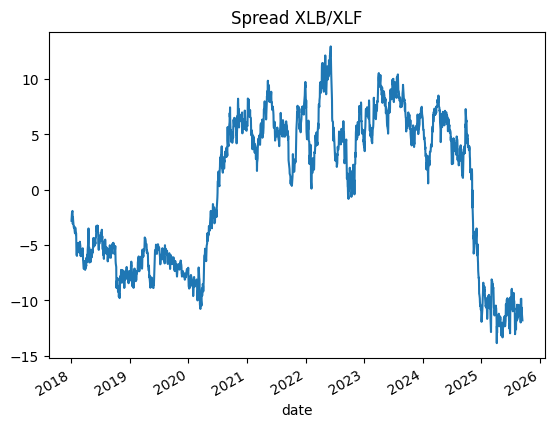

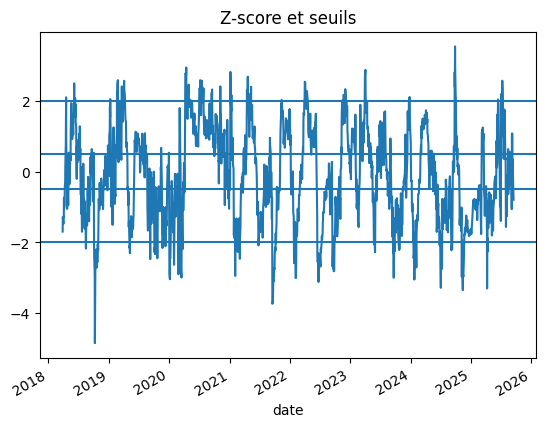

In [10]:
a, b = top.loc[0, 'a'], top.loc[0, 'b']
dfa = price_map[a]['close']
dfb = price_map[b]['close']
alpha, beta = ols_hedge_ratio(dfa, dfb)
spr = spread_series(dfa, dfb, alpha, beta)
z = zscore(spr, params['lookbacks']['zscore_days'])
fig = plt.figure(); spr.plot(); plt.title(f'Spread {a}/{b}'); plt.show()
fig2 = plt.figure(); z.plot();
plt.axhline(params['thresholds']['entry_z']); plt.axhline(-params['thresholds']['entry_z']);
plt.axhline(params['thresholds']['exit_z']); plt.axhline(-params['thresholds']['exit_z']);
plt.title('Z-score et seuils'); plt.show()


In [11]:
# Additional analysis: Show trading signals and statistics
print(f"\n=== Analysis for {a}/{b} ===")
print(f"Correlation: {top.loc[0, 'rho']:.4f}")
print(f"Half-life: {top.loc[0, 'half_life']:.2f} days")
print(f"P-value (cointegration): {top.loc[0, 'pval']}")
print(f"Hedge ratio (β): {beta:.4f}")
print(f"Alpha: {alpha:.4f}")

# Count potential signals
entry_signals = (abs(z) >= params['thresholds']['entry_z']).sum()
print(f"\nPotential entry signals (|z| >= {params['thresholds']['entry_z']}): {entry_signals}")

# Show current z-score
current_z = z.iloc[-1] if not z.empty else 0
print(f"Current z-score: {current_z:.2f}")

if abs(current_z) >= params['thresholds']['entry_z']:
    print("🔥 SIGNAL: Entry threshold reached!")
elif abs(current_z) <= params['thresholds']['exit_z']:
    print("✅ No position signal")
else:
    print("⏳ Monitoring zone")

# Show some statistics
print(f"\nSpread statistics:")
print(f"Mean: {spr.mean():.2f}")
print(f"Std: {spr.std():.2f}")
print(f"Min: {spr.min():.2f}")
print(f"Max: {spr.max():.2f}")


=== Analysis for XLB/XLF ===
Correlation: 0.9701
Half-life: 2.03 days
P-value (cointegration): 0.02
Hedge ratio (β): 1.4970
Alpha: 22.4011

Potential entry signals (|z| >= 2.0): 237
Current z-score: -0.80
⏳ Monitoring zone

Spread statistics:
Mean: -0.00
Std: 6.81
Min: -13.88
Max: 12.96
